# Single-qubit Data-Reuploading Classifier

In [1]:
from os import environ
environ["OMP_NUM_THREADS"] = "1"

In [22]:
%config InlineBackend.figure_format='retina'
import pennylane as qml
from pennylane import PauliX, PauliY, PauliZ, expval, RX, RY, RZ, Rot

import torch
import numpy as np
# from torch import tensor, pi, sqrt, exp
from torch.nn import Softmax, CrossEntropyLoss, Module, Parameter
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from seaborn import set_palette, color_palette
from tqdm import tqdm, trange

from sklearn.model_selection import train_test_split

from IPython.display import clear_output  # for showing the plot dynamically
from datetime import datetime

set_palette('Set2')  # for better color

## Dataset Preview

In [3]:
X, y = torch.load('fmnist02.pt')

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                        test_size=.2, random_state=0)

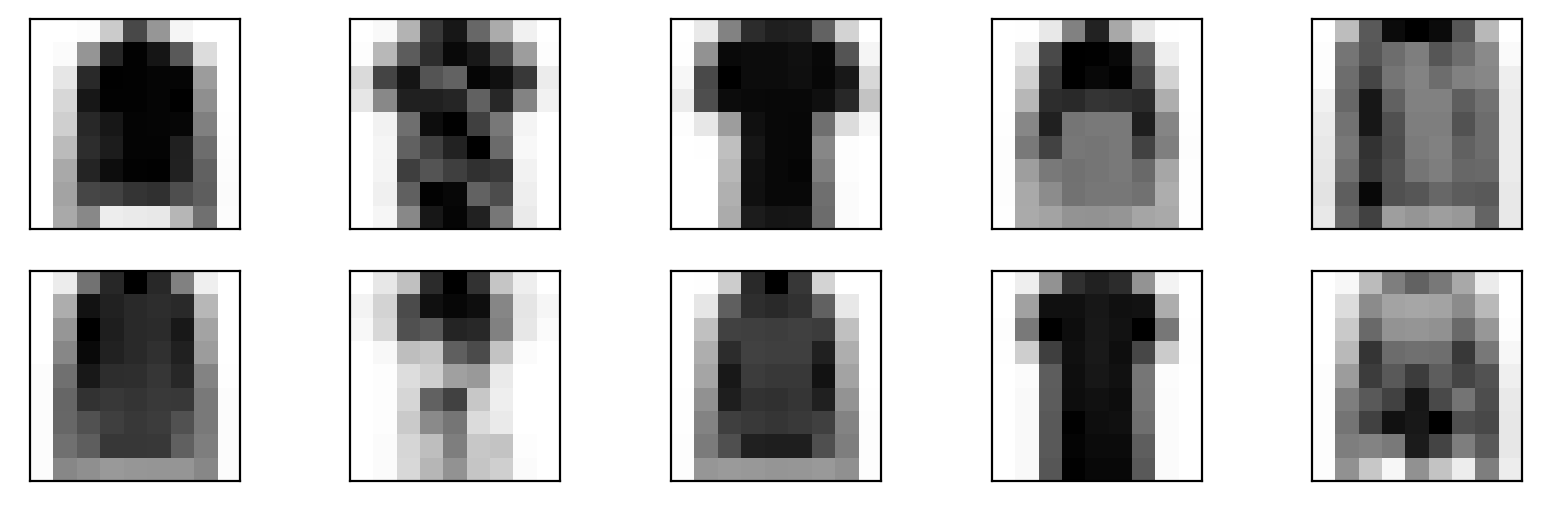

In [5]:
fig, ax = plt.subplots(2, 5, figsize=(10, 3))
for x, a in zip(X_train[:10], ax.flatten()):
    a.imshow(x.reshape(9, 9), cmap='gray_r')
    a.set_xticks([])
    a.set_yticks([])

In [6]:
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

## Single-qubit Model

In [7]:
n_qubits = 1
dev = qml.device('lightning.qubit', wires=n_qubits)

In [8]:
def reuploading(x, weights, bias, n_qubits, entanglement_pattern=None):
    '''
    x: a flattend feature vector
    weights: n_layers x dim(x)
    bias: n_layers x dim(x)
    
    break down high dimensional vector automatically down to all qubits.
    '''
    
    assert weights.shape == bias.shape
    
    # pad x so that it is a multiple of 3.
    extra_digits = (len(x) + 2) // 3 * 3 - len(x)
    x = torch.cat([x, torch.zeros(extra_digits)])
    
    n_layers = len(bias)
    for l in range(n_layers):
        # how many times to repeat
        xx = weights[l] * x + bias[l]
        xx = xx.reshape(n_qubits, -1, 3)
        for j in range(xx.shape[1]):
            # break down high-dim data
            qml.broadcast(qml.Rot, wires=range(n_qubits), pattern='single', parameters=xx[:, j])
            if entanglement_pattern != None:
                if l != n_layers - 1 or j != xx.shape[1] - 1:  # omit last one
                    qml.broadcast(qml.CZ, wires=range(n_qubits), pattern=entanglement_pattern)

In [9]:
@qml.qnode(dev, diff_method='adjoint', interface='torch')
def circuit(inputs, weights, bias):
    
    reuploading(inputs, weights, bias, len(dev.wires))
    
    # p0 = qml.Projector(basis_state=tensor([0]), wires=dev.wires)
    return expval(PauliZ(0))  # use <P0> = 1/2(1 + <Z>) for faster simulation

In [10]:
class ReuploadingQuantumNetwork(Module):
    
    def __init__(self, quantum_layer):
        super(ReuploadingQuantumNetwork, self).__init__()
        # self.bias = Parameter(torch.zeros(1))
        self.quantum_layer = quantum_layer
        
    def forward(self, x):
        '''
        recall the output of the quantum circuit is <P_0>
        '''
        x = self.quantum_layer(x)
        # x += self.bias
        # return (x + 1) / 2  # use <P0> = 1/2(1 + <Z>) for faster simulation
        x = (x + 1) / 2
        return torch.stack([x, 1-x], dim=1)  # return the prob for each for consistency
    
    def pred(self, X_test):
        '''
        <P_0> near 1 is interpreted as class 0.
        '''
        return (self.forward(X_test)[:,0] < .5).long()
    
    def score(self, X_test, y_test):
        pred = self.pred(X_test)
        return (pred == y_test).float().mean()
    
    def simplified_fidelity_loss(self, x, y):
        expectation_p0 = self.forward(x)[:,0]
        return (expectation_p0 + y - 1).pow(2).sum()

In [18]:
def plot_explanation(x, x0=None):
    
    with torch.no_grad():
        pred = model.pred(x)
    x_ig = integrated_grad(x_test=x, model=model, x0=x0)
    x_grad = vanilla_grad(x_test=x, model=model)
    x_ip = grad_x_input(x_test=x, model=model, vanilla=x_grad)
    # x_sg = smooth_grad(x_test=x, model=model, method=vanilla_grad, noise=.2, n=30)
    
    x_ig, x_grad, x_ip = x_ig.cpu(), x_grad.cpu(), x_ip.cpu()
    x = x.detach().cpu()
    
    fig, ax = plt.subplots(len(x), 4, figsize=(7. / 5 * 4, 1.5 * len(x)))
    fig_width = torch.sqrt(torch.tensor(x[0].flatten().shape)).int().item()
    
    for r, ax_row in enumerate(ax):
        ax_row[0].imshow(x[r].reshape(fig_width, -1), cmap='gray_r')
        ax_row[0].set_title(f'pred: {pred[r]}')
        ax_row[0].set_ylabel(r)

        vmin = min([torch.min(x_grad[r]), torch.min(x_ip[r]), torch.min(x_ig[r])])
        vmax = max([torch.max(x_grad[r]), torch.max(x_ip[r]), torch.max(x_ig[r])])
        vmax = max(abs(vmin), abs(vmax))
        vmin = -vmax
        norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
        
        im1 = centered_attribution_plot(ax_row[1], x_grad[r], norm=norm)
        im2 = centered_attribution_plot(ax_row[2], x_ip[r], norm=norm)
        im3 = centered_attribution_plot(ax_row[3], x_ig[r], norm=norm)
        # im4 = centered_attribution_plot(ax_row[4], x_sg[r], norm=norm)
        
        ax_row[1].set_title('saliency')
        ax_row[2].set_title(r'G$\odot$I')
        ax_row[3].set_title('IG')
        # ax_row[4].set_title('Smooth')

        fig.colorbar(im1, ax=ax_row, fraction=0.046, pad=0.04)
        
    # plt.tight_layout()
    
    del x_ig, x_grad, x_ip
    torch.cuda.empty_cache()

## Training

In [12]:
n_features = 81
n_layers = 1
param_shapes = {'weights':(n_layers, n_features), 'bias':(n_layers, n_features)}
init_method = {'weights':lambda x: torch.nn.init.uniform_(x, -0.05, 0.05), 'bias':torch.nn.init.zeros_}
q_layer = qml.qnn.TorchLayer(circuit, param_shapes, init_method)

In [13]:
model = ReuploadingQuantumNetwork(q_layer)
model.load_state_dict(torch.load('fmnist_1layers2023-06-02T17:15:03.pt'))

<All keys matched successfully>

In [14]:
%%time
# before training:
print('train score:', model.score(X_train[:200], y_train[:200]))
print('test score:', model.score(X_test[:200], y_test[:200]))

/home/liukdiihmieu/miniconda3/envs/lab/lib/python3.9/site-packages/pennylane/tape/qscript.py:569: UserWarning: The get_operation will soon be updated to also return the index of the trainable operation in the tape. If you want to switch to the new behavior, you can pass `return_op_index=True`
  warnings.warn(


train score: tensor(0.9500)
test score: tensor(0.9600)
CPU times: user 3.56 s, sys: 44 ms, total: 3.6 s
Wall time: 3.6 s


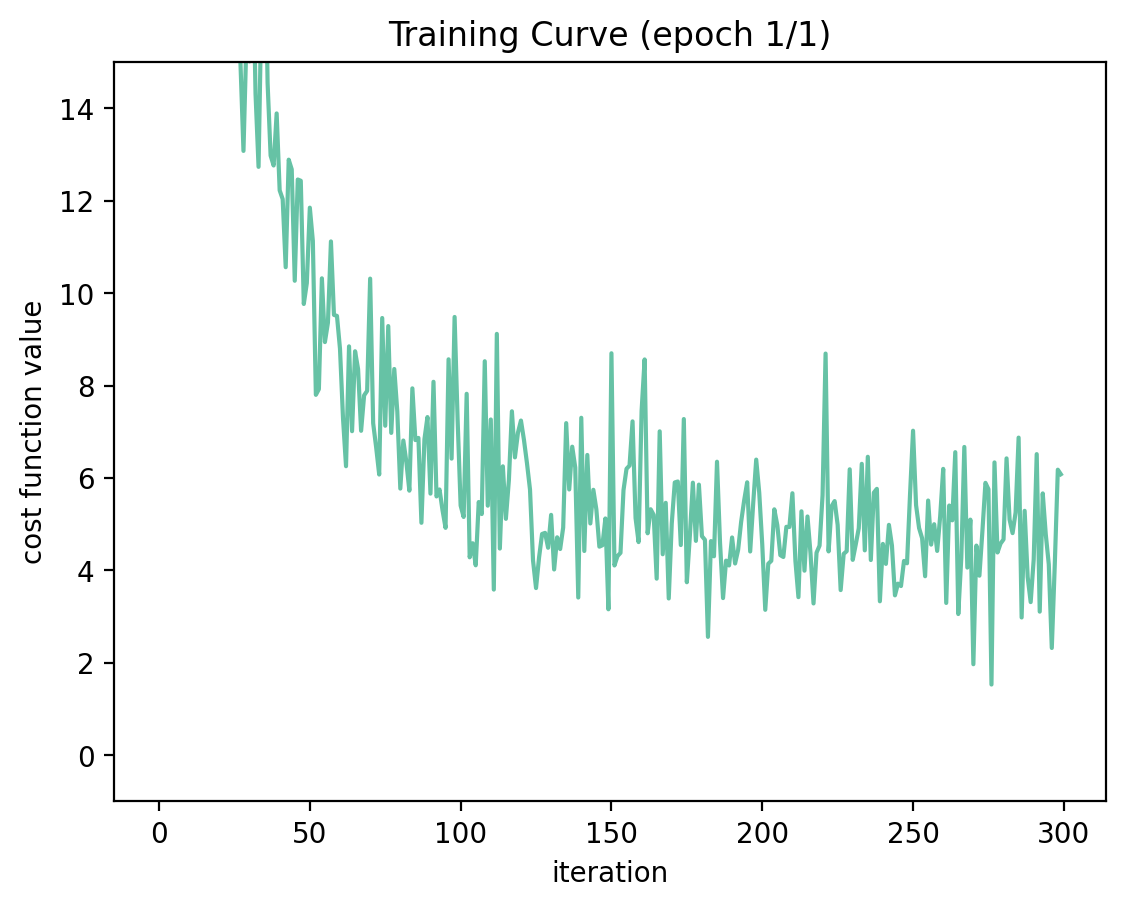

100%|███████████████████████████████████████████| 75/75 [01:58<00:00,  1.57s/it]


In [22]:
from IPython.display import clear_output  # for showing the plot dynamically
set_palette('Set2')  # for better color

n_epochs = 1

# warning: large learning rate leads to local minimum here.
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)
loss_fn = CrossEntropyLoss()

# cost_hist = []  # correct history data
for epoch in range(n_epochs):
    for x_batch, y_batch in tqdm(dataloader):
        loss = model.simplified_fidelity_loss(x_batch, y_batch)
        # pred = model(x_batch)
        # loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        
        cost_hist.append(loss.item())
        
        # dynamic plot of the training curve
        clear_output(wait=True)
        plt.title(f'Training Curve (epoch {epoch+1}/{n_epochs})')
        plt.xlabel('iteration')
        plt.ylabel('cost function value')
        plt.plot(cost_hist)
        plt.ylim([-1, 15])
        plt.show()

In [25]:
print('train score:', model.score(X_train[:200], y_train[:200]))
print('test score:', model.score(X_test[:200], y_test[:200]))
torch.save(model.state_dict(), f'fmnist_1layers{datetime.now().isoformat(timespec="seconds")}.pt')

train score: tensor(0.9500)
test score: tensor(0.9600)


## Feature Attribution

In [15]:
from IntegratedGrad import *

for p in model.parameters():
    p.requires_grad_(False)

In [22]:
def plot_ig_path(ax, x, model, x0=None):
    if x0 is None:
        x0 = torch.zeros_like(x)
    alpha = torch.linspace(0, 1, 50)
    x_path = alpha.unsqueeze(1) @ (x - x0).unsqueeze(0) + x0
    y_path = model(x_path).detach()[:, 0]
    ax.plot(alpha, y_path)
    ax.set_ylim([0, 1])

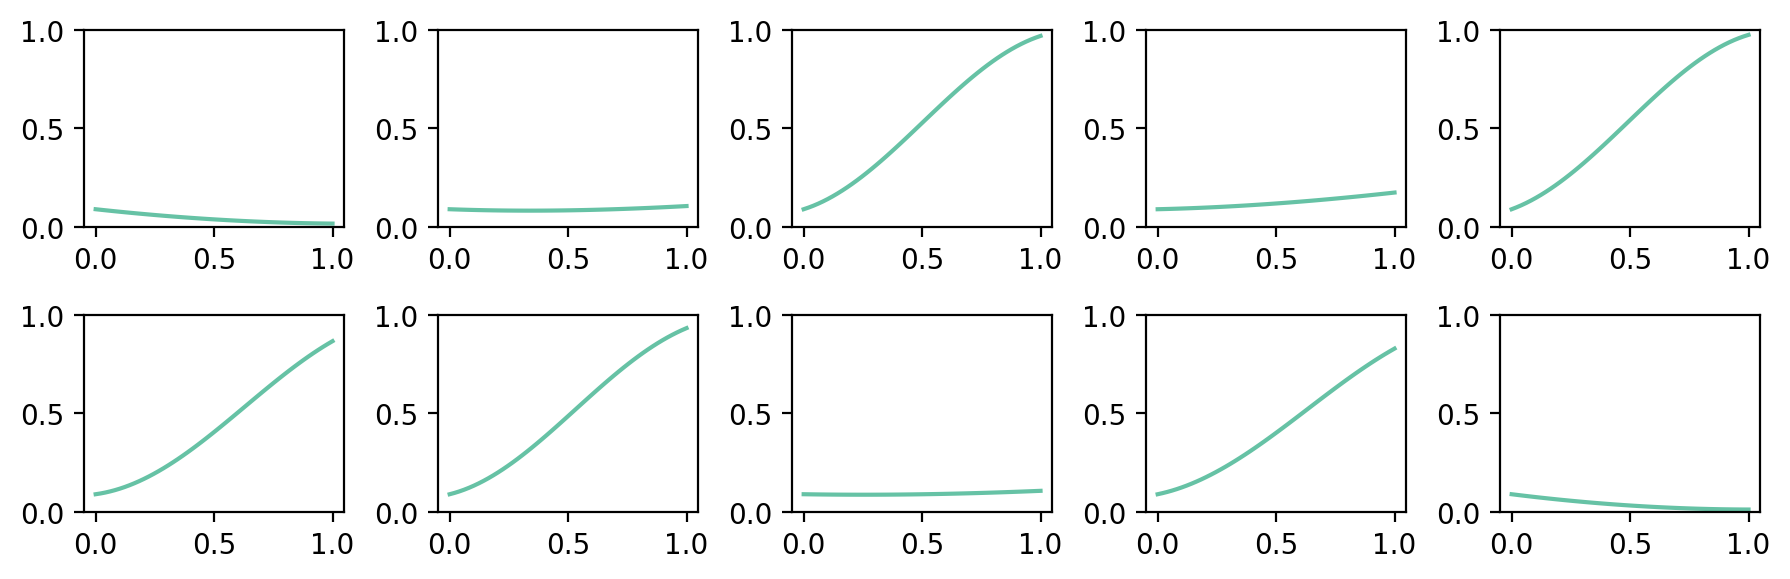

In [23]:
fig, ax = plt.subplots(2, 5, figsize=(9, 3))
for i, a in enumerate(ax.flatten()):
    plot_ig_path(a, X_test[-10+i], model)
plt.tight_layout()

In [25]:
result_saliency = []
result_GxI = []
result_IG = []
# result_SG = []

# result_saliency, result_GxI, result_IG = np.load(
#     'saved_models/sens-n_2layer_2022-12-25T23:45:13.npy')

sample = torch.randperm(len(X_test))[:50]
for i in tqdm(sample):
    attr_saliency = vanilla_grad(X_test[i], model)
    attr_GxI = grad_x_input(X_test[i], model, vanilla=attr_saliency)
    attr_IG = integrated_grad(X_test[i], model)
    # attr_SG = smooth_grad(X[i], model, method=vanilla_grad, noise=.2, n=30)
    # rs, rg, ri, rsg = sensitivity_n(model, int(30 * 0.8), 
                               # [attr_saliency, attr_GxI, attr_IG, attr_SG], X[i])
    rs, rg, ri = sensitivity_n(model, int(n_features * 0.8), [attr_saliency, attr_GxI, attr_IG], X_test[i])
    result_saliency.append(rs)
    result_GxI.append(rg)
    result_IG.append(ri)
    # result_SG.append(rsg)

  0%|                                                    | 0/50 [00:00<?, ?it/s]/home/liukdiihmieu/miniconda3/envs/lab/lib/python3.9/site-packages/pennylane/tape/qscript.py:569: UserWarning: The get_operation will soon be updated to also return the index of the trainable operation in the tape. If you want to switch to the new behavior, you can pass `return_op_index=True`
  warnings.warn(
100%|███████████████████████████████████████████| 50/50 [34:40<00:00, 41.60s/it]


In [27]:
with open(f'sens-n_1layers_fmnist{datetime.now().isoformat(timespec="seconds")}.npy', 'wb') as f:
    np.save(f, [result_saliency, result_GxI, result_IG])

In [28]:
def plot_sensitivity_n(*results, labels):
    
    assert len(results) == len(labels)
    
    fig, ax = plt.subplots(figsize=(5, 3.5))
    for r, l in zip(results, labels):
        r = np.array(r)
        ax.plot(range(1, len(r.mean(0)) + 1), r.mean(0), label=l)
        ax.fill_between(range(1, len(r.mean(0)) + 1), r.mean(0) - r.std(0) / 2, r.mean(0) + r.std(0) / 2, alpha=.2)
    ax.set_xlabel('feature subset size')
    ax.set_ylabel('correlation')
    # ax.legend()

In [30]:
import tikzplotlib

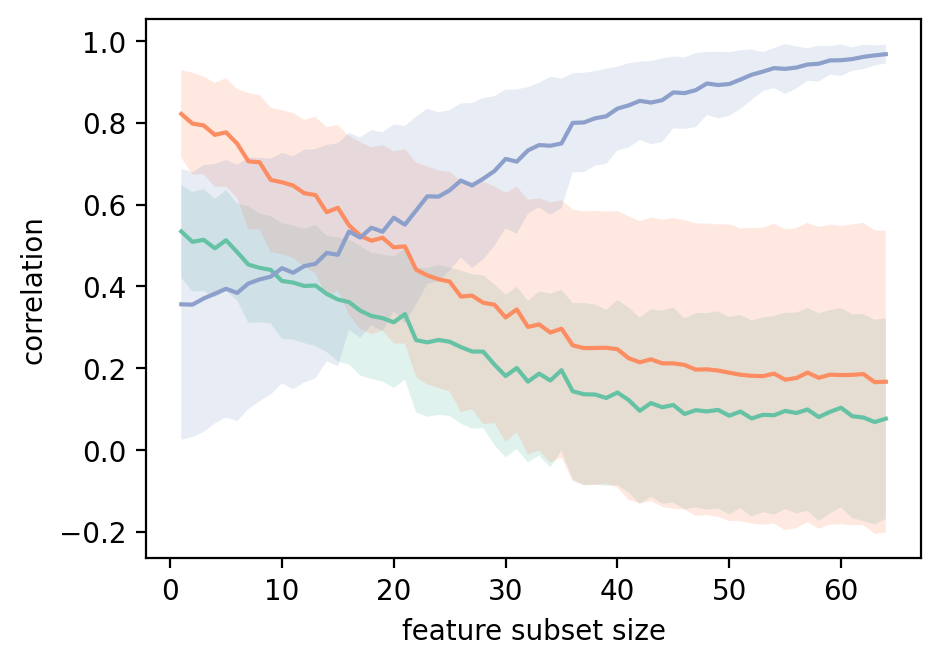

In [31]:
labels = ['saliency', r'G$\odot$I', 'IG']
plot_sensitivity_n(result_saliency, result_GxI, result_IG, labels=labels)
tikzplotlib.save('fmnist_reup_sens_n.tex')

In [17]:
sample_instances = X_test[torch.randperm(len(X_test))[:50]]
bar_list = []
# bar_list = np.load('saved_models/sens-max_2layer_2022-12-25T23:45:20.npy')

for method in [vanilla_grad, grad_x_input, integrated_grad]:
    sens_list = []
    for instance in tqdm(sample_instances):
        sens_list.append(sensmax_monte_carlo(model, method, instance, 0.1))
    bar_list.append(sens_list)

100%|███████████████████████████████████████████| 50/50 [13:21<00:00, 16.02s/it]


In [20]:
with open(f'sens-max_1layers_fmnist{datetime.now().isoformat(timespec="seconds")}.npy', 'wb') as f:
    np.save(f, bar_list)

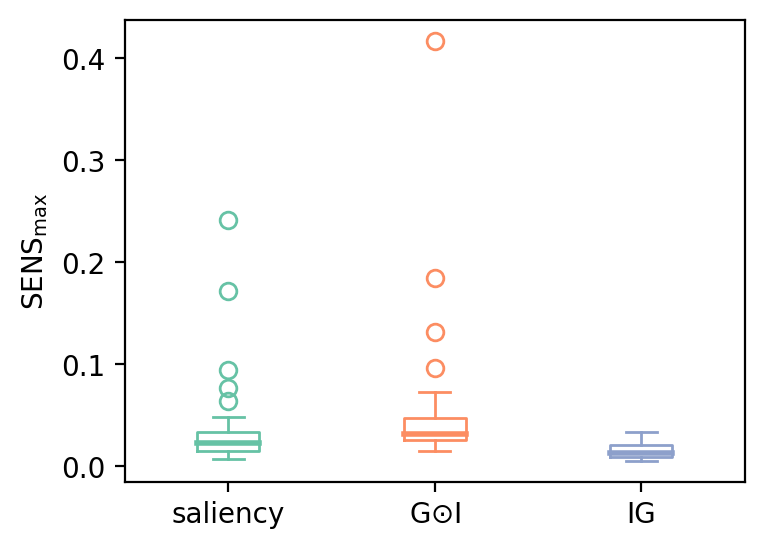

In [33]:
import tikzplotlib
fig, ax = plt.subplots(figsize=(4, 3))
colors = color_palette('Set2')  # get colors from the palette

box_plot = ax.boxplot(bar_list, labels=['saliency', r'G$\odot$I', 'IG'])
ax.set_ylabel(r'SENS$_\mathrm{max}$')

# Iterate through each boxplot and customize the colors
for i, box in enumerate(box_plot['boxes']):
    # Set the color of the box
    box.set_color(colors[i])

for i, whisker in enumerate(box_plot['whiskers']):
    # Set the color of the whiskers
    whisker.set_color(colors[i // 2])

for i, cap in enumerate(box_plot['caps']):
    # Set the color of the caps
    cap.set_color(colors[i // 2])

for i, median in enumerate(box_plot['medians']):
    # Set the color of the medians
    median.set_color(colors[i])
    median.set_linewidth(2)

for i, flier in enumerate(box_plot['fliers']):
    # Set the color of the fliers
    flier.set_markeredgecolor(colors[i])

tikzplotlib.save('box.tex')

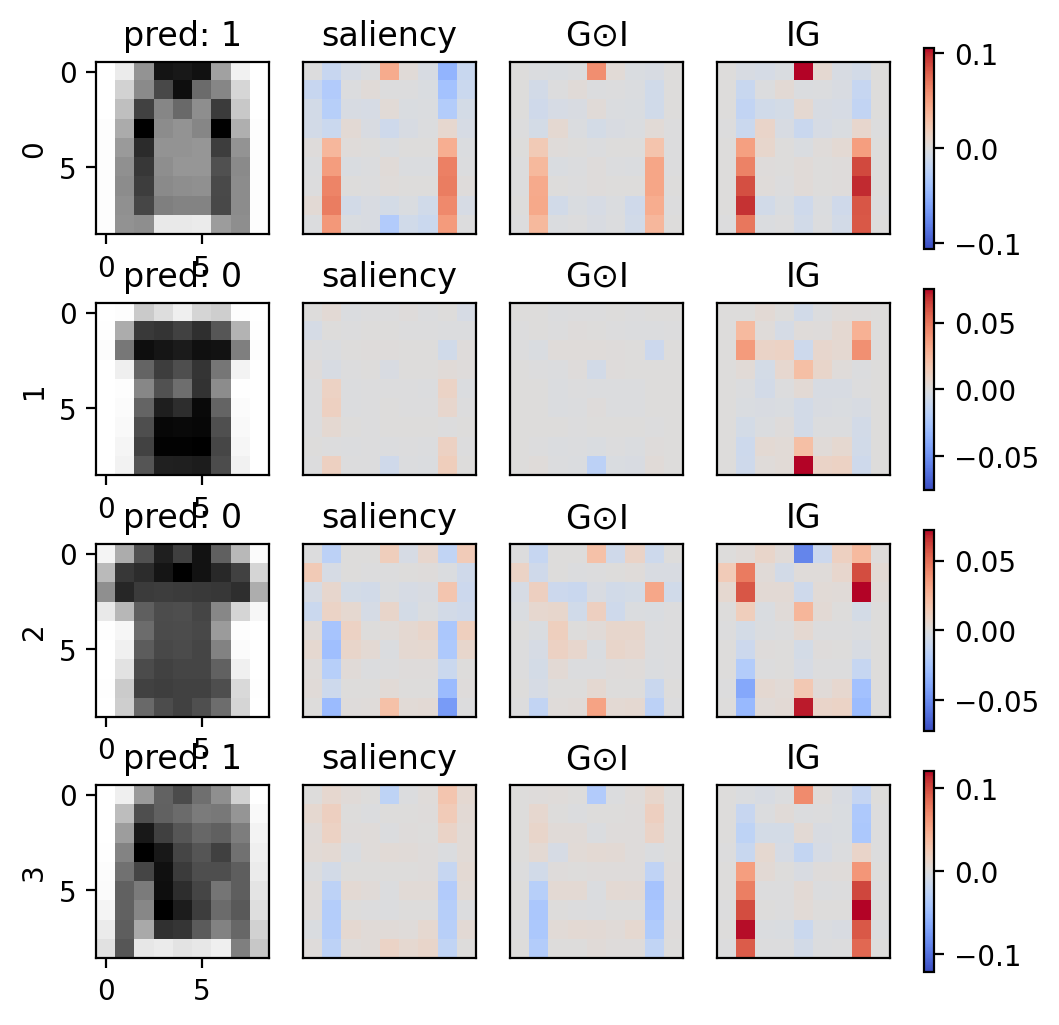

In [24]:
plot_explanation(X_test[-4:])
plt.savefig('fmnist_reup.pdf')